In [14]:
#!pip install pyomo

import numpy as np
import pyomo.environ as pyo
from pathlib import *
from pyomo.opt import SolverFactory
from gurobipy import *

import os
import pandas as pd
import matplotlib.pyplot as plt
import statistics
import time

from datetime import datetime
param = {
"WLSACCESSID": '31c22531-09db-4b06-8466-f0589ec53ca2',
"WLSSECRET": '1db38aec-7d75-4e91-aadb-aed504137cf7',
"LICENSEID": 943442,
}

gurobi_environment = Env(params=param)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 943442
Academic license 943442 - for non-commercial use only - registered to j.___@student.vu.nl


# Generating instance

In [15]:
class demand_object:
    def __init__(self, index, interarrival_time, x_coordinate, y_coordinate, service_time, earliest_arrival):
        self.index = index
        self.interarrival_time = interarrival_time
        self.x_coordinate = x_coordinate
        self.y_coordinate = y_coordinate
        self.service_time = service_time
        self.earliest_arrival = earliest_arrival

def generate_instance(system_loads, simulation_demands_amount, tilde_n, m , mu, lam, sigma, num_sets_tilde_A):
    
    A_all = []
    S_all = []
    x_coordinates = []
    y_coordinates = []
    
    depot_x_coord = m/2
    depot_y_coord = m/2
    
    # Fill the demands object
    depot_object = demand_object(0, 0, depot_x_coord, depot_y_coord, 0, 0)
    demands = [depot_object]
    
    for i in range(simulation_demands_amount):
        np.random.seed(i)
        A = np.random.exponential(1/lam, size=1)[0] # Interarrival times vector 
        S = np.random.normal(mu, sigma, size = 1)[0]
        x_coordinate = np.random.uniform(low=0, high=m, size=1)[0]
        y_coordinate = np.random.uniform(low=0, high=m, size=1)[0]
        demand_i = demand_object(i+1, A, x_coordinate, y_coordinate , S, demands[i].earliest_arrival+A)
        demands.append(demand_i)
    
    
    # Construct tilde A vector
    release_times_tilde_A = [0]*num_sets_tilde_A 
    previous_release_tilde_A = 0
    demands_tilde_A = []

    for i in range(num_sets_tilde_A):
        subset = [depot_object]
        subset.extend(demands[i*tilde_n+1:(i+1)*tilde_n+1])
        demands_tilde_A.append(subset)
        release_times_tilde_A[i] = subset[-1].earliest_arrival
        
    return demands_tilde_A, demands, release_times_tilde_A

In [16]:
system_loads = 0.3

tilde_n = 19; # Size o/f the subsets N_k
simulation_demands_amount = 5000*tilde_n # Maximum number of demands per simulation
m = 1 # Square region A has size m x m
mu = 1/10;
lam = system_loads/mu; # Arrival rate of individual dynamic demands
sigma = 0;
num_sets_tilde_A = int(simulation_demands_amount/tilde_n)

demands_tilde_A, demands, release_times_tilde_A = generate_instance(system_loads, simulation_demands_amount, tilde_n, m , mu, lam, sigma, num_sets_tilde_A)

#print(release_times_tilde_A)

In [17]:
# Check requirement on n
print("Load:", lam*mu)
print("lam:", lam)
print("mu:", mu)

requirement = ((lam*0.72*m)**2)/((1-(lam*mu))**2)
print(f"n satisfies the condition: {tilde_n > requirement}")
print(f"Requirement value of n: {requirement}")

if not (tilde_n > requirement):
    raise ValueError("TSP requirement not met")

Load: 0.3
lam: 2.9999999999999996
mu: 0.1
n satisfies the condition: True
Requirement value of n: 9.521632653061223


# Distances matrix

In [18]:
# Compute distances matrices
def Compute_distances(tilde_A_demands, num_sets_tilde_A, n):
    distances_matrices = []
    for i in range(num_sets_tilde_A):
        partial_matrix = np.zeros((n, n),dtype=float )
        for j in range(n):
            for k in range(n):
                if k > j:
                    distance = np.sqrt((tilde_A_demands[i][j].x_coordinate - tilde_A_demands[i][k].x_coordinate)**2 + (tilde_A_demands[i][j].y_coordinate - tilde_A_demands[i][k].y_coordinate)**2)
                    partial_matrix[j][k] = round(distance, 14)
                    partial_matrix[k][j] = round(distance, 14)
                    
        distances_matrices.append(partial_matrix)
        
    return distances_matrices

distances_matrices = Compute_distances(demands_tilde_A, num_sets_tilde_A, len(demands_tilde_A[0]))

In [19]:
def Compute_TSP_Tour(distances_matrix, gurobi_environment):
    global mu
    
    model = Model(env = gurobi_environment)
    model.Params.LogToConsole = 0

    # Parameters
    tilde_n = len(distances_matrix)-1

    # Nodes set
    nodes = range(tilde_n+1) # produce list from 0 through tilde n 
    nodes_excl = range(1,tilde_n+1)
    tour = model.addMVar((tilde_n+1, tilde_n+1), vtype=GRB.BINARY, name="tour")
    u = model.addMVar(tilde_n+1, vtype= GRB.CONTINUOUS, lb = 0, ub = GRB.INFINITY)
    
    model.setObjective(sum(tour[i, j] * distances_matrix[i,j] for i in nodes for j in nodes if i != j), GRB.MINIMIZE)
    
    model.addConstrs(sum(tour[i, j] for j in nodes if i != j) == 1 for i in nodes_excl)
    model.addConstrs(sum(tour[i, j] for i in nodes if i != j) == 1 for j in nodes_excl)
    model.addConstr(sum(tour[i, 0] for i in nodes_excl) == 1)

    # Eliminate subtours using Miller-Tucker-Zemlin (MTZ) Constraints
    model.addConstr(u[0] == 1)
    model.addConstrs(u[i] - u[j] + ((tilde_n+1)*tour[i,j]) <= tilde_n for i in nodes_excl for j in nodes_excl if i != j)

    model.optimize();
    optimality = model.status
    result = tour.X
    
    return result, optimality

# Solve model

In [20]:
all_adjacency_matrices = []
total_travel_times_subsets = [0]*num_sets_tilde_A
all_TSP_Tours = []

class TSP_object:
    def __init__(self, index, travel_time):
        self.index = index
        self.travel_time = travel_time

        
general_start_time = time.time() # START TIME

start_time = time.time() # START TIME
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print(f"Starting time = {current_time}")

for i in range(num_sets_tilde_A):
    
    #"""STATUS PRINTING"""
    if ((time.time()-start_time)/60 >= 0.5):
        now = datetime.now()
        now_time = now.strftime("%H:%M:%S")
        print(f"{now_time}: NUMBER TSP TOURS COMPUTED: {i+1}/{num_sets_tilde_A}")
        start_time = time.time()
    #"""STATUS PRINTING"""
    
    # Solving
    result, optimality = Compute_TSP_Tour(distances_matrices[i], gurobi_environment);
    
    #print(f"\niteration {i+1}/{num_sets_tilde_A}: {(time.time() - start_time)/60} minutes")   
    #print(f"Optimal solution? {optimality == 2}")
    
    # Make tour array
    TSP_tour = [TSP_object(0,0)]
    current_node = 0
    for l in range(tilde_n+1):
        adjacency_row = result[current_node]
        next_node = np.where(adjacency_row == max(adjacency_row))[0][0]
        
        #"""TSP VALIDITY CHECK"""
        for k in range(l):
            if (next_node == TSP_tour[k].index and next_node != 0):
                print(next_node)
                print(result)
                raise ValueError(f"Node {next_node+(i*tilde_n)} visited twice")
        #"""TSP VALIDITY CHECK"""
        
        TSP_tour.append(TSP_object(next_node+(i*tilde_n), distances_matrices[i][current_node][next_node]))
        current_node = next_node
        
    #print("TSP tour length", len(TSP_tour))
    all_TSP_Tours.append(TSP_tour)
    
print(f"\nI have finished in {(time.time() - general_start_time)/60} minutes")       

Starting time = 18:35:33
18:36:04: NUMBER TSP TOURS COMPUTED: 22/5000
18:36:34: NUMBER TSP TOURS COMPUTED: 41/5000
18:37:05: NUMBER TSP TOURS COMPUTED: 58/5000
18:37:37: NUMBER TSP TOURS COMPUTED: 76/5000
18:38:07: NUMBER TSP TOURS COMPUTED: 94/5000
18:38:38: NUMBER TSP TOURS COMPUTED: 116/5000
18:39:09: NUMBER TSP TOURS COMPUTED: 138/5000
18:39:40: NUMBER TSP TOURS COMPUTED: 159/5000
18:40:10: NUMBER TSP TOURS COMPUTED: 180/5000
18:40:42: NUMBER TSP TOURS COMPUTED: 200/5000
18:41:13: NUMBER TSP TOURS COMPUTED: 220/5000
18:41:44: NUMBER TSP TOURS COMPUTED: 239/5000
18:42:15: NUMBER TSP TOURS COMPUTED: 260/5000
18:42:46: NUMBER TSP TOURS COMPUTED: 281/5000
18:43:16: NUMBER TSP TOURS COMPUTED: 297/5000
18:43:46: NUMBER TSP TOURS COMPUTED: 316/5000
18:44:16: NUMBER TSP TOURS COMPUTED: 334/5000
18:44:48: NUMBER TSP TOURS COMPUTED: 350/5000
18:45:18: NUMBER TSP TOURS COMPUTED: 374/5000
18:45:49: NUMBER TSP TOURS COMPUTED: 400/5000
18:46:20: NUMBER TSP TOURS COMPUTED: 427/5000
18:46:51: NUMB

20:05:46: NUMBER TSP TOURS COMPUTED: 4056/5000
20:06:17: NUMBER TSP TOURS COMPUTED: 4079/5000
20:06:47: NUMBER TSP TOURS COMPUTED: 4101/5000
20:07:18: NUMBER TSP TOURS COMPUTED: 4124/5000
20:07:48: NUMBER TSP TOURS COMPUTED: 4147/5000
20:08:18: NUMBER TSP TOURS COMPUTED: 4169/5000
20:08:49: NUMBER TSP TOURS COMPUTED: 4193/5000
20:09:19: NUMBER TSP TOURS COMPUTED: 4219/5000
20:09:49: NUMBER TSP TOURS COMPUTED: 4243/5000
20:10:20: NUMBER TSP TOURS COMPUTED: 4268/5000
20:10:50: NUMBER TSP TOURS COMPUTED: 4293/5000
20:11:22: NUMBER TSP TOURS COMPUTED: 4318/5000
20:11:53: NUMBER TSP TOURS COMPUTED: 4340/5000
20:12:23: NUMBER TSP TOURS COMPUTED: 4365/5000
20:12:54: NUMBER TSP TOURS COMPUTED: 4390/5000
20:13:25: NUMBER TSP TOURS COMPUTED: 4413/5000
20:13:56: NUMBER TSP TOURS COMPUTED: 4434/5000
20:14:27: NUMBER TSP TOURS COMPUTED: 4457/5000
20:14:57: NUMBER TSP TOURS COMPUTED: 4481/5000
20:15:27: NUMBER TSP TOURS COMPUTED: 4505/5000
20:15:59: NUMBER TSP TOURS COMPUTED: 4529/5000
20:16:29: NUM

# Compute waiting times

In [21]:
class result:
    def __init__(self, index, earliest_arrival, completion_time, waiting_time):
        self.index = index
        self.earliest_arrival = earliest_arrival
        self.completion_time = completion_time
        self.waiting_time = waiting_time

results = []
ending_time_prev_TSP = 0.0

for i in range(num_sets_tilde_A):
    temp_tour = all_TSP_Tours[i]
    sum_service_times_tilde_A = 0.0
    sum_travel_times_tilde_A = 0.0
    start_time_TSP = max(ending_time_prev_TSP, release_times_tilde_A[i])
    
    for j in range(1,tilde_n+1):
        index = temp_tour[j].index
        prev_index = temp_tour[j-1].index
        
        sum_travel_times_tilde_A += temp_tour[j].travel_time
        wait_within_TSP = sum_travel_times_tilde_A + sum_service_times_tilde_A
        wait_before_TSP = start_time_TSP - demands[index].earliest_arrival
        sum_service_times_tilde_A += demands[index].service_time
        waiting_time = wait_within_TSP + wait_before_TSP
        completion_time = start_time_TSP+wait_within_TSP+demands[index].service_time
        results.append(result(index, demands[index].earliest_arrival, completion_time, waiting_time))        

    distance_back_to_depot = np.sqrt((demands[index].x_coordinate - (m/2))**2 + (demands[index].y_coordinate - (m/2))**2)
    ending_time_prev_TSP = completion_time + distance_back_to_depot


# Plotting

In [22]:
result_waiting_times_array = []
convergence = []
convergence_sum = 0;
for k in range(simulation_demands_amount):
    result_waiting_times_array.append(results[k].waiting_time)
    convergence_sum += results[k].waiting_time
    convergence.append(convergence_sum/(k+1))

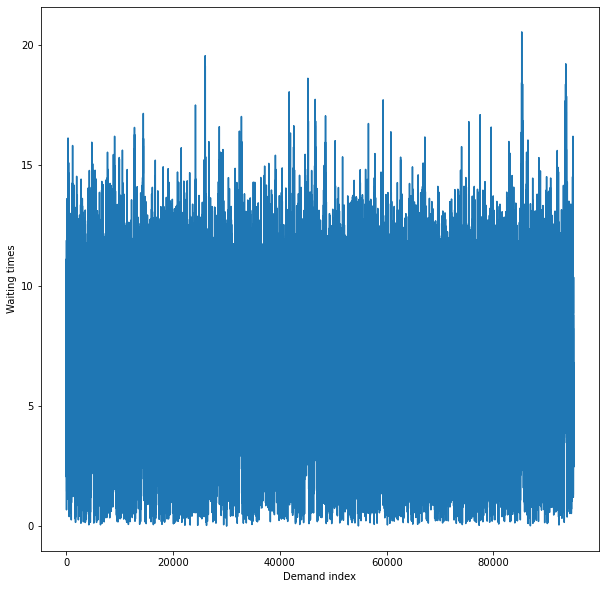

In [23]:
plt.figure(figsize=(10, 10))

plt.plot(range(simulation_demands_amount), result_waiting_times_array)

plt.title('')
plt.xlabel('Demand index')
plt.ylabel('Waiting times')
plt.show()

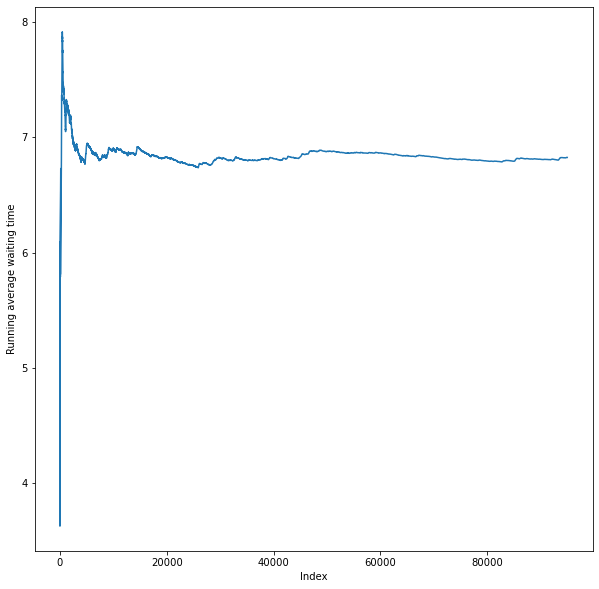

In [24]:
plt.figure(figsize=(10, 10))

plt.plot(range(simulation_demands_amount), convergence)

plt.title('')
plt.xlabel('Index')
plt.ylabel('Running average waiting time')
plt.show()

## Results - Waiting Times - Batch Means

In [25]:
warm_up_period = 500*tilde_n
sample_size = 110*tilde_n

number_of_samples = int((simulation_demands_amount-warm_up_period)/sample_size)
print(f"number of samples = {number_of_samples}")

batch_sample = []
for j in range(number_of_samples):
    mean_sample = np.mean(result_waiting_times_array[warm_up_period+(j*sample_size):warm_up_period+((j+1)*sample_size)])
    batch_sample.append(mean_sample)
CI = [np.mean(batch_sample) - (1.96*statistics.stdev(batch_sample)/np.sqrt(number_of_samples)),np.mean(batch_sample) + (1.96*statistics.stdev(batch_sample)/np.sqrt(number_of_samples))]
variation = (statistics.stdev(batch_sample))

print(f"Waiting time mean = {np.mean(batch_sample):.4f}")
print(f"Standard deviation waiting time = {variation:.4f}")
print(f"Waiting time CI = [{CI[0]:.4f},{CI[1]:.4f}]")

number of samples = 40
Waiting time mean = 6.7930
Standard deviation waiting time = 0.3377
Waiting time CI = [6.6883,6.8977]
